<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/ArkhipovAS-folder/ArkhipovAS_selector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Система Selector



## Импорт библиотек

In [22]:
# Для операций с тензорами
import numpy as np

# Для отрисвоки
import matplotlib.pyplot as plt

# Для создания модели
from tensorflow.keras.models import Model

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Слои для латентного пространства модели
from tensorflow.keras.layers import Flatten, Reshape, Dense

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для загрузки базы
from tensorflow.keras.datasets import mnist

from google.colab import drive # Для работы с Google Drive
from google.colab import files # Для работы с файлами 
from distutils.dir_util import copy_tree
import contextlib
import shutil
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

## Загрузка данных

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!rm -R '/content/selector/' # Проверяем наличие папки selector. Если есть, удаляем ее

In [7]:
# Проверяем, существует ли папка
if not os.path.exists('/content/selector'):
    # Создаем папку
    os.makedirs('/content/selector')

In [8]:
# Указываем путь к базе в Google Drive, создаем папку и извлекаем туда базу
!unzip -q '/content/drive/MyDrive/ai/Base/dataset.zip' -d '/content/selector'

In [ ]:
# Используем shutil
#shutil.copytree("/content/drive/MyDrive/trousers_men_true_1967", "/content/selector/dataset/trousers_men")
shutil.copytree("/content/drive/MyDrive/t-shirt_men_true_984", "/content/selector/dataset/t-shirt_men")

'/content/selector/dataset/t-shirt_men'

In [ ]:
# Открываем изображение
img = Image.open("/content/selector/dataset/trousers_men/1008.jpg")

# Получаем размеры изображения
width, height = img.size

# Получаем количество каналов
channels = img.getbands()

# Выводим информацию об изображении
print(f"Ширина: {width}, Высота: {height}")
print(f"Количество каналов: {len(channels)}")

Ширина: 1200, Высота: 1800
Количество каналов: 3


In [11]:
FILE_DIR  = '/content/selector/dataset'
dir_list = os.listdir(FILE_DIR)
print(dir_list)

['sportswear men', 't-shirt women', 'dress solemn', 'dress casual', 'dress homemade', 'trousers men', 'sportswear women', 'shirt men', 'trousers women', 'dress  business', 't-shirt men', 'shirt women']


In [13]:
# Изменяем размер изображения до 200х200
IMG_WIDTH = 200
IMG_HEIGHT = 200

# Переменные для отслеживания текущей папки и количества обработанных изображений
current_folder = ""
processed_images = 0

# Проходим по папкам и файлам внутри каталога
for root, dirs, files in os.walk(FILE_DIR):
    for filename in files:
        # Полный путь к файлу
        file_path = os.path.join(root, filename)

        # Проверяем, является ли файл изображением
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # Открываем изображение, изменяем его размер и преобразуем в оттенки серого
            img = Image.open(file_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")

            # Сохраняем измененное изображение обратно
            img.save(file_path)

            # Увеличиваем счетчик обработанных изображений в текущей папке
            processed_images += 1


    # Выводим сообщение после обработки каждой папки
    if current_folder != root:
        if current_folder:
            print(f"Папка {current_folder} обработана. Количество обработанных изображений: {processed_images}")
        current_folder = root
        processed_images = 0

# Выводим сообщение для последней обработанной папки
if current_folder:
    print(f"Папка {current_folder} обработана. Количество обработанных изображений: {processed_images}")

Папка /content/selector/dataset обработана. Количество обработанных изображений: 904
Папка /content/selector/dataset/sportswear men обработана. Количество обработанных изображений: 1171
Папка /content/selector/dataset/t-shirt women обработана. Количество обработанных изображений: 638
Папка /content/selector/dataset/dress solemn обработана. Количество обработанных изображений: 805
Папка /content/selector/dataset/dress casual обработана. Количество обработанных изображений: 974
Папка /content/selector/dataset/dress homemade обработана. Количество обработанных изображений: 1780
Папка /content/selector/dataset/trousers men обработана. Количество обработанных изображений: 714


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Папка /content/selector/dataset/sportswear women обработана. Количество обработанных изображений: 2863
Папка /content/selector/dataset/shirt men обработана. Количество обработанных изображений: 986
Папка /content/selector/dataset/trousers women обработана. Количество обработанных изображений: 463
Папка /content/selector/dataset/dress  business обработана. Количество обработанных изображений: 1069
Папка /content/selector/dataset/t-shirt men обработана. Количество обработанных изображений: 1033
Папка /content/selector/dataset/shirt women обработана. Количество обработанных изображений: 0


In [16]:
# Путь к папке, которую нужно архивировать
source_folder = "/content/selector/dataset"

# Путь к папке, в которую нужно скопировать архив
destination_folder = "/content/drive/MyDrive/ai/Base/"

# Имя архива
archive_name = "dataset_conv.zip"

# Архивируем папку
shutil.make_archive("/content/selector/dataset_conv", "zip", source_folder)

# Копируем архив в другую папку
shutil.copy("/content/selector/dataset_conv.zip", f"{destination_folder}/{archive_name}")

'/content/drive/MyDrive/ai/Base//dataset_conv.zip'

In [27]:
# Инициализация списков для хранения изображений и меток классов
x_data = []
y_data = []

# Проходим по папкам и файлам внутри каталога
for root, dirs, files in os.walk(FILE_DIR):
    for filename in files:
        # Полный путь к файлу
        file_path = os.path.join(root, filename)

        # Проверяем, является ли файл изображением
        if filename.endswith((".jpg", ".jpeg", ".png")):

            # Преобразуем изображение в массив numpy
            img_array = np.array(img)

            # Добавляем изображение в список x_train
            x_data.append(img_array)

            # Получаем метку класса из имени папки, в которой находится файл
            class_label = os.path.basename(root)

            # Добавляем метку класса в список y_train
            y_data.append(class_label)

# Преобразуем списки в массивы numpy
x_data = np.array(x_data)
y_data = np.array(y_data)

# Преобразуем метки классов в формат One-Hot Encoding
label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(y_data)
y_data_onehot = to_categorical(y_data_encoded)

# Выводим размеры массивов x_train и y_train_onehot
print("Размеры x_data:", x_data.shape)
print("Размеры y_data_onehot:", y_data_onehot.shape)

Размеры x_data: (13400, 200, 200)
Размеры y_data_onehot: (13400, 12)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data_onehot, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость


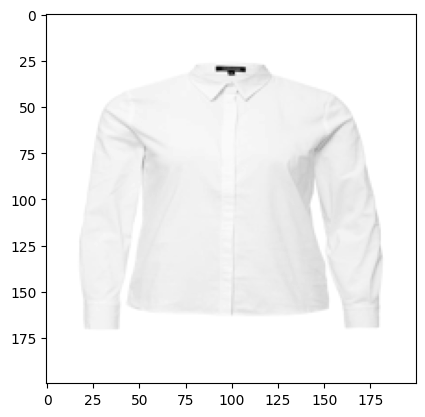

In [29]:
plt.imshow(x_train[109], cmap='gray')  # cmap='gray' используется для отображения изображения в оттенках серого
plt.show()

# Автокодировщик

In [ ]:
def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(200, 200, 1)) # 200, 200, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(200*200, activation='sigmoid')(input_encoded)
    decoded = Reshape((200, 200, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(X_train, X_train,
                       epochs=10,
                       batch_size=256,
                       callbacks=[ae_callback],
                       validation_data=(X_test, X_test))